In [ ]:
# Import important libraries
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import gdown
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Constants
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Downloading And Loading the dataset

In [ ]:
# Google Drive file_ids of commercial and non-commercial audio-video features
commercialFeatures_150_file_id          = "1SS1P4E_4i4B5ZPVF5TkoZKGE2hixJZeB"
nonCommercialFeatures_150_file_id       = "1SWvWM5YEDdBmfizxoNKVFEX7EU6hjqkx"

# Destination paths
commercialFeatures_150_destination      = "commercialFeatures_150.pkl"
nonCommercialFeatures_150_destination   = "nonCommercialFeatures_150.pkl"

In [ ]:
def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive if it doesn't already exist locally.

    Parameters:
    - file_id (str): The unique file ID from Google Drive.
    - destination (str): The local path where the file should be saved.
    """
    if os.path.exists(destination):
        print(f'File already exists at {destination}. Skipping download.')
    else:
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, destination, quiet=False)

In [ ]:
# Downloading commercialFeatures
download_file_from_google_drive(commercialFeatures_150_file_id, commercialFeatures_150_destination)

# Downloading nonCommercialFeatures
download_file_from_google_drive(nonCommercialFeatures_150_file_id, nonCommercialFeatures_150_destination)

Downloading...
From (original): https://drive.google.com/uc?id=1SS1P4E_4i4B5ZPVF5TkoZKGE2hixJZeB
From (redirected): https://drive.google.com/uc?id=1SS1P4E_4i4B5ZPVF5TkoZKGE2hixJZeB&confirm=t&uuid=30e7bff5-7a0d-483f-b9bf-68a5d27c53b8
To: /content/commercialFeatures_150.pkl
100%|██████████| 980M/980M [00:08<00:00, 121MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1SWvWM5YEDdBmfizxoNKVFEX7EU6hjqkx
From (redirected): https://drive.google.com/uc?id=1SWvWM5YEDdBmfizxoNKVFEX7EU6hjqkx&confirm=t&uuid=5fb05511-51b3-46ef-94c7-fe1314c1cc85
To: /content/nonCommercialFeatures_150.pkl
100%|██████████| 1.08G/1.08G [00:10<00:00, 103MB/s]


In [ ]:
def load_features():
    """
    Load data from a pickled file if it exists, otherwise initialize an empty list.

    Returns:
    - commercialFeatures_150 (list) - List containing Commercial video features
    - nonCommercialFeatures_150 (list) - List containing nonCommercial video features
    """
    with open('commercialFeatures_150.pkl', 'rb') as f:
        commercialFeatures_150 = pickle.load(f)
    with open('nonCommercialFeatures_150.pkl', 'rb') as f:
        nonCommercialFeatures_150 = pickle.load(f)
    # Move tensors to GPU explicitly
    # with tf.device('/GPU:0'):
    #     commercialFeatures_150_tensor_gpu = tf.convert_to_tensor(commercialFeatures_150, dtype=tf.float32)
    #     nonCommercialFeatures_150_tensor_gpu = tf.convert_to_tensor(nonCommercialFeatures_150, dtype=tf.float32)
    print(f'Number of commercial features: {len(commercialFeatures_150)}')
    print(f'Number of nonCommercial features: {len(nonCommercialFeatures_150)}')
    print("Audio-Visual Features Loaded Successfully")
    return commercialFeatures_150, nonCommercialFeatures_150

In [ ]:
commercialFeatures_150, nonCommercialFeatures_150 = load_features()

Number of commercial features: 4364
Number of nonCommercial features: 4600
Audio-Visual Features Loaded Successfully


# Dataset Preprocessing

In [ ]:
def preprocess_features(max_frames, features):
    """
    Preprocess video features by trimming or padding them to a fixed number of frames.

    Parameters:
    - max_frames (int) - The maximum number of frames each video should have.
    - features (list of ndarray) -  A list where each element is a numpy array representing the features of a video. Each array is of shape (number_of_frames, number_Vf).

    Returns:
    - video_data (ndarray) -  A numpy array of shape (num_videos, max_frames, number_Vf) containing the preprocessed video data.
    """
    num_videos = len(features)
    number_Vf = 1024
    video_data = np.zeros((num_videos, max_frames, number_Vf))

    # Process each video
    for i, video in enumerate(features):
        length = len(video)
        if length >= max_frames:
            # Trim the video if longer than max_frames
            video_data[i, :, :] = video[:max_frames]
        else:
            # Pad the video with zeros if shorter than max_frames
            video_data[i, :length, :] = video

    return video_data

In [ ]:
def convertToNumpyArray(features):
    """
    Convert a list of features to a NumPy array.

    Parameters:
    - features (list) - A list of features to be converted to a NumPy array.

    Returns:
    - numpy.ndarray: A NumPy array containing the elements of the input list.
    """
    return np.array(features)

In [ ]:
# trim commercial features to sequence_length = 150
commercialFeatures_150 = preprocess_features(150, commercialFeatures_150)
nonCommercialFeatures_150 = preprocess_features(150, nonCommercialFeatures_150)

In [ ]:
print(commercialFeatures_150.shape)
print(nonCommercialFeatures_150.shape)

(4364, 150, 1024)
(4600, 150, 1024)


In [ ]:
print(commercialFeatures_150.dtype)
print(nonCommercialFeatures_150.dtype)

float64
float64


# Generating labels for data and merging commercial and non-commercial features and shuffling data randomly

In [ ]:
# Generating labels
commercial_labels = np.ones(len(commercialFeatures_150))
non_commercial_labels = np.zeros(len(nonCommercialFeatures_150))

In [ ]:
# Merging commercial and non-commercial features
X = np.concatenate((commercialFeatures_150, nonCommercialFeatures_150), axis=0)
Y = np.concatenate((commercial_labels, non_commercial_labels), axis=0)

In [ ]:
print(f'Shape of data is {X.shape}')
print(f'Shape of labels is {Y.shape}')

Shape of data is (8964, 150, 1024)
Shape of labels is (8964,)


In [ ]:
# Shuffling data randomly
X, Y = shuffle(X, Y, random_state=42)

# Preprocess the data

In [ ]:
print(X[0][0])

[  0.  72. 173. ... 142. 119. 137.]


In [ ]:
# Finding Range of data
maxi = 0
mini = 1000
for i in range(len(X[0][0])):
    maxi = max(maxi, X[0][0][i])
    mini = min(mini, X[0][0][i])

In [ ]:
print(f'maximum value is {maxi}')
print(f'minimum value is {mini}')

maximum value is 255.0
minimum value is 0.0


In [ ]:
def scale_data(data):
    """
    Scale the input data by dividing by 255.

    Parameters:
    data (numpy.ndarray): Input data array of shape [samples, features] or higher dimensions.

    Returns:
    numpy.ndarray: Scaled data with values in the range [0, 1].
    """

    scaled_data = data / 255.0
    return scaled_data

In [ ]:
X = scale_data(X)

In [ ]:
print(X[0][0])

[0.         0.28235294 0.67843137 ... 0.55686275 0.46666667 0.5372549 ]


In [ ]:
# Finding Range of data
maxi = 0
mini = 1000
for i in range(len(X[0][0])):
    maxi = max(maxi, X[0][0][i])
    mini = min(mini, X[0][0][i])

In [ ]:
print(f'maximum value is {maxi}')
print(f'minimum value is {mini}')

maximum value is 1.0
minimum value is 0.0


# Generating Calibration Data

In [ ]:
X.shape

(8964, 150, 1024)

In [ ]:
Y.shape

(8964,)

In [ ]:
X_cal_data = X[:50]
Y_cal_data = Y[:50]
print(X_cal_data.shape)
print(Y_cal_data.shape)

(50, 150, 1024)
(50,)


In [ ]:
X = X[50:]
Y = Y[50:]

In [ ]:
print(X.shape)
print(Y.shape)

(8914, 150, 1024)
(8914,)


In [ ]:
# Finding Range of data
maxi = 0
mini = 1000
for i in range(len(X[0][0])):
    maxi = max(maxi, X[0][0][i])
    mini = min(mini, X[0][0][i])

In [ ]:
print(f'maximum value is {maxi}')
print(f'minimum value is {mini}')

maximum value is 1.0
minimum value is 0.0


# Train, Test and Validation split

In [ ]:
def split_data(data, labels, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1, random_state=None):
    """
    Split data into training, validation, and test sets.

    Parameters:
    data (numpy.ndarray): The input data of shape [samples, features].
    labels (numpy.ndarray): The corresponding labels of shape [samples,].
    train_ratio (float): The ratio of the training set. Default is 0.7.
    valid_ratio (float): The ratio of the validation set. Default is 0.15.
    test_ratio (float): The ratio of the test set. Default is 0.15.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: Tuple containing:
        - train_data (numpy.ndarray): Training data.
        - valid_data (numpy.ndarray): Validation data.
        - test_data (numpy.ndarray): Test data.
        - train_labels (numpy.ndarray): Training labels.
        - valid_labels (numpy.ndarray): Validation labels.
        - test_labels (numpy.ndarray): Test labels.
    """

    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios must sum to 1."

    train_data, temp_data, train_labels, temp_labels = train_test_split(
        data, labels, test_size=(1 - train_ratio), random_state=random_state
    )

    temp_ratio = valid_ratio + test_ratio
    valid_ratio_relative = valid_ratio / temp_ratio
    test_ratio_relative = test_ratio / temp_ratio

    valid_data, test_data, valid_labels, test_labels = train_test_split(
        temp_data, temp_labels, test_size=test_ratio_relative, random_state=random_state
    )

    return train_data, valid_data, test_data, train_labels, valid_labels, test_labels

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, Y, random_state=42)


In [ ]:
del X
del Y
del commercialFeatures_150
del nonCommercialFeatures_150
del commercial_labels
del non_commercial_labels

In [ ]:
print(f'Train data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (7131, 150, 1024)
Validation data shape: (891, 150, 1024)
Test data shape: (892, 150, 1024)


In [ ]:
print(f'Train labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test labels shape: {y_test.shape}')

Train labels shape: (7131,)
Validation labels shape: (891,)
Test labels shape: (892,)


# CNNs Model

In [ ]:
def cnn_model():
    model = Sequential()
    model.add(Reshape((150, 1024, 1), input_shape=(150, 1024)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (150, 1024)
cnn_model = cnn_model()
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 150, 1024, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 1024, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 512, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 512, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 256, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 303104)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      38,797,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,810,561 (148.05 MB)

 Trainable params: 38,810,561 (148.05 MB)

 Non-trainable params: 0 (0.00 B)

## Model training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
    # callbacks=[early_stopping]
)

Epoch 1/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5908 - loss: 1.1803 - val_accuracy: 0.8687 - val_loss: 0.2970
Epoch 2/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9126 - loss: 0.2241 - val_accuracy: 0.9394 - val_loss: 0.1654
Epoch 3/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9671 - loss: 0.0924 - val_accuracy: 0.9315 - val_loss: 0.1991
Epoch 4/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9866 - loss: 0.0413 - val_accuracy: 0.9315 - val_loss: 0.2052
Epoch 5/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9920 - loss: 0.0245 - val_accuracy: 0.9315 - val_loss: 0.2220
Epoch 6/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9921 - loss: 0.0246 - val_accuracy: 0.9371 - val_loss: 0.2603
Epoch 7/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9922 - loss: 0.0249 - val_accuracy: 0.9214 - val_loss: 0.3328
Epoch 8/20
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9971 - loss: 0.0104 - val_acc

## Model Evaluation

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9324 - loss: 0.2168


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.23777884244918823
Test Accuracy: 0.9327354431152344


In [ ]:
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


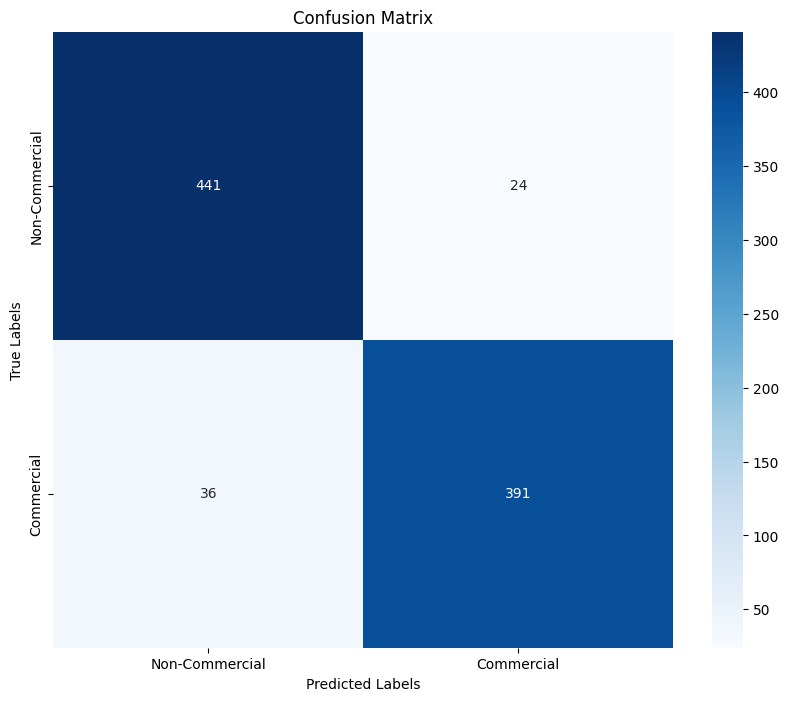

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Commercial', 'Commercial'], yticklabels=['Non-Commercial', 'Commercial'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Setting Batch Size to 1

In [ ]:
config  = cnn_model.get_config()

In [ ]:
for layer in config['layers']:
    if 'batch_shape' in layer['config']:
        shape = layer['config']['batch_shape']
        shape = (1, *shape[1:])
        layer['config']['batch_shape'] = shape

In [ ]:
config

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (1, 150, 1024),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Reshape',
   'config': {'name': 'reshape',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'target_shape': (150, 1024, 1)},
   'registered_name': None,
   'build_config': {'input_shape': (None, 150, 1024)}},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    '

In [ ]:
cnn_model_new = cnn_model.from_config(config)

In [ ]:
cnn_model_new.set_weights(cnn_model.get_weights())

In [ ]:
cnn_model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (1, 150, 1024, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (1, 150, 1024, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (1, 75, 512, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (1, 75, 512, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (1, 37, 256, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (1, 303104)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 128)                    │      38,797,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 128)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (1, 64)                     │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,810,561 (148.05 MB)

 Trainable params: 38,810,561 (148.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model_new.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
test_loss, test_accuracy = cnn_model_new.evaluate(X_test, y_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9324 - loss: 0.2168


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.23777884244918823
Test Accuracy: 0.9327354431152344


## Converting the Trained CNN model to .tflite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model_new)
converter.experimental_new_converter = True
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpfnvegxk6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 150, 1024), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(1, 1), dtype=tf.float32, name=None)
Captures:
  138433876446192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138433876443904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138433876455696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138433876457984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138427773012272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138427773015792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138427773018960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138427773022480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138427773025472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138428742192464: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Save the converted model
with open('cnn_model.tflite', 'wb') as f:
    f.write(tflite_model)

## Inferencing on .tflite model

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='./cnn_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter = tf.lite.Interpreter(model_path='./cnn_model.tflite')

In [ ]:
interpreter.allocate_tensors()

In [ ]:
def run_inference(input_data):
    """
    Run inference on a single input using the TensorFlow Lite interpreter.

    Parameters:
    input_data (np.ndarray): The input data for the model. Should be a NumPy array with the appropriate shape.

    Returns:
    output_data (np.ndarray): The output data from the model. The shape and type of this output depend on the model's architecture.
    """
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data


In [ ]:
def evaluate_model(interpreter, X_test, y_test, threshold=0.5):
    """
    Evaluate the TensorFlow Lite model on the given test dataset.

    Parameters:
    interpreter (tf.lite.Interpreter): The TensorFlow Lite interpreter for running inference.
    X_test (np.ndarray): The test dataset input features. Should be a NumPy array of shape (n_samples, seq_len, n_features).
    y_test (np.ndarray): The test dataset labels. Should be a NumPy array of shape (n_samples,).
    threshold (float, optional): he threshold for binary classification. Default is 0.5.

    Returns:
    accuracy (float): The accuracy of the model on the test dataset.
    """
    correct_predictions = 0
    total_predictions = 0

    for i in range(len(X_test)):
        input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)  # Adding batch dimension
        predicted_output = run_inference(input_data)
        predicted_label = (predicted_output >= threshold).astype(int)[0][0]  # Applying threshold
        true_label = y_test[i]

        if predicted_label == true_label:
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
accuracy = evaluate_model(interpreter, X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9327354260089686


In [ ]:
X_test.shape

(892, 150, 1024)

In [ ]:
y_test.shape

(892,)

# Saving the Test data




In [ ]:
y_test.shape

(892,)

In [ ]:
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [ ]:
# Load the arrays from .npy files
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [ ]:
X_test.shape

In [ ]:
size1 = os.path.getsize('X_test.npy') / (1024 * 1024)  # Size in MB
size2 = os.path.getsize('y_test.npy') / (1024 * 1024)  # Size in MB

In [ ]:
size1

1175.9766845703125

In [ ]:
size2

0.006927490234375

In [ ]:
from google.colab import files
files.download('X_test.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('y_test.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.save('X_cal_data.npy', X_cal_data)
np.save('Y_cal_data.npy', Y_cal_data)

In [ ]:
from google.colab import files
files.download('X_cal_data.npy')
from google.colab import files
files.download('Y_cal_data.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("hi")

hi
